<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

In [5]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [6]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = datos.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


In [ ]:
data.shape[0]

1194119

In [ ]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(12258,)
(64663,)


In [ ]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

1067977
1185365


In [7]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [ ]:
data.shape[0]

1060109

In [36]:
# la frecuencia de cada cue
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [37]:
new_df

,Word,Frequency
0,up,2021
1,not,1167
2,out,1061
3,on,961
4,down,830
...,...,...
11868,ping,33
11869,Homer,29
11870,adrenal,26
11871,Sherlock,23


Text(0, 0.5, 'frequency')

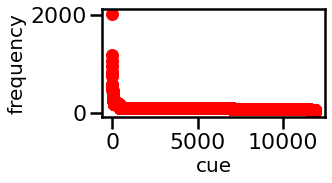

In [48]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

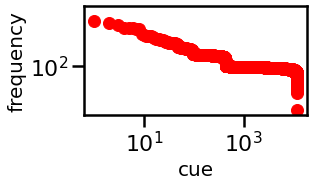

In [39]:
#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [40]:
# la frecuencia de cada R1
new_df_R1 = data['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

Text(0, 0.5, 'frequency')

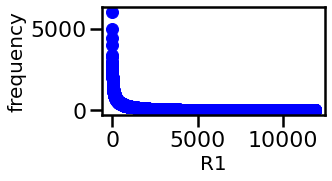

In [47]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

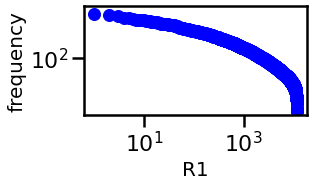

In [42]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [8]:
#sacando los duplicados
data_0 = data[data.duplicated()]
print(data_0.shape[0])

674293


In [13]:
# calculando frecuencia de aparicion de cada cue
df1_0 = data_0.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_0_sorted = df1_0.sort_values(by=['size'],ascending=False).reset_index()
df1_0_sorted.head(5)

,index,cue,size
0,62,Cheddar,92
1,7129,mozzarella,92
2,7059,moo,91
3,1909,cardiac,91
4,304,Sahara,91


In [14]:
# calculando frecuencia de aparicion de R1
df3_0 = data_0.groupby(['R1']).size().to_frame(name='size').reset_index()
df3_0_sorted = df3_0.sort_values(by=['size'],ascending=False).reset_index()
df3_0_sorted.head(5)

,index,R1,size
0,6499,money,5166
1,4149,food,3883
2,10915,water,3630
3,1760,car,3305
4,6619,music,2794


In [44]:
# calculando frecuencia de aparicion de cada par cue-R1
df2_0 = data_0.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_0_sorted = df2_0.sort_values(by=['size'],ascending=False).reset_index()
df2_0_sorted.head(5)

,index,cue,R1,size
0,591,Cheddar,cheese,92
1,2523,Parmesan,cheese,91
2,76260,moo,cow,90
3,55638,halt,stop,86
4,77017,mozzarella,cheese,85


In [16]:
df_0 = df2_0.merge(df1_0,left_on='cue',right_on='cue')
df_0 = df_0.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df_0['frec'] = df_0['frec_par']/df_0['frec_cue']
df_0.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


distribuciones de frecuencias despues de limpiar datos

Text(0, 0.5, 'frequency')

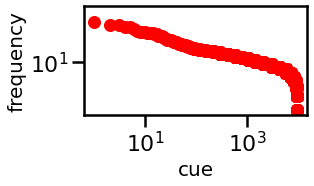

In [49]:
auxc = df_0['cue'].str.split(expand=True).stack().value_counts().reset_index()
auxc.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxc['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

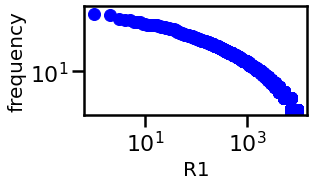

In [50]:
auxp = df_0['R1'].str.split(expand=True).stack().value_counts().reset_index()
auxp.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxp['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

despues de limpiarlos se parecen un poco mas a una small world pero no son exactamente

In [18]:
# Recortando el grafo

df_0 = df_0[df_0['frec']>0.025]

# Sacar palabras que no estan mas en el cue y la R1 otra vez
df_0.drop(df_0[df_0['R1'].isin(df_0['cue'].unique())==False].index, inplace=True)
df_0.drop(df_0[df_0['cue'].isin(df_0['R1'].unique())==False].index, inplace=True)
print(df_0.shape[0])

In [22]:
df_0.shape

(72583, 5)

Matriz de adyacencia

In [52]:
df_firstrows = pd.crosstab(df_0.cue, df_0.R1)
idx = df_firstrows.columns.union(df_firstrows.index)
matriz = df_firstrows.reindex(index = idx, columns=idx, fill_value=0) #armo la matriz de adyacencia

In [ ]:
matriz.head()

El grafo con la matriz de adyacencia:

In [53]:
G1_0= nx.from_pandas_adjacency(matriz)

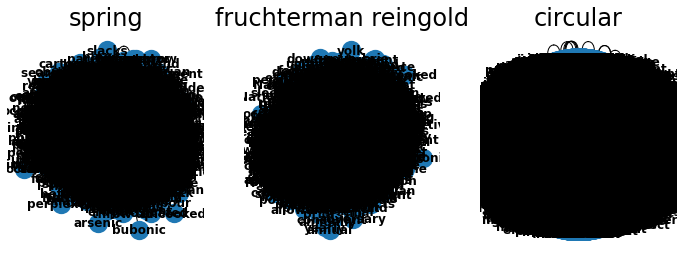

In [54]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('circular');

El grafo con la funcion edgelist (no entiendo bien la diferencia con el metodo de la matriz de adyacencia):

In [24]:
G1 = nx.from_pandas_edgelist(df_0[['cue','R1']],source='cue',target='R1',edge_attr=None)

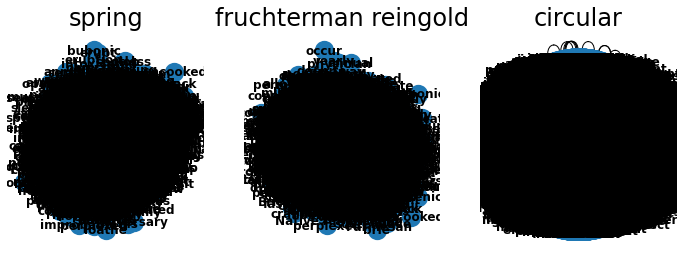

In [25]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G1, with_labels=True,alpha=0.6)
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=False,alpha=0.4)
plt.title('circular');



No se ve nada igual

In [28]:
df1_0 = df_0[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2_0 = df_0[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict_0 = pd.concat([df1_0,df2_0])  # concatenando
list_dict_0 = df_dict_0['word'].unique() #eliminando duplicados
list_dict_0.shape

(9906,)

In [29]:
print('numero nodos',len(list_dict_0))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_0)*(len(list_dict_0)))

numero nodos 9906
numero maximo aristas (no dirigidas y sin loops) 49059465.0
numero maximo aristas (dirigidas y sin loops) 98118930
numero maximo aristas (dirigidas y con loops) 98128836


Histograma sobre los pesos (tomados como las frecuencias de las parejas):

Text(0.5, 1.0, 'Histograma aristas')

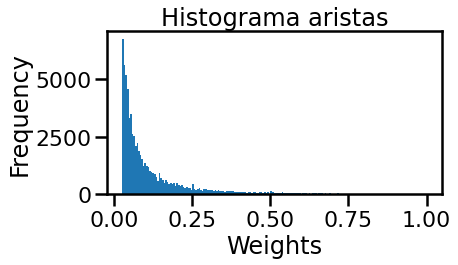

In [66]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_0['frec'],bins='auto')
plt.ylabel('Frequency')
plt.xlabel('Weights');
plt.title('Histograma aristas')

In [ ]:
plt.figure()
nodo_salida = [n1 for n1, n2, att in G_per.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_per.edges(data=True)]
weights = [att['weight'] for n1, n2, att in G_per.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');
plt.title('Histograma solo sobre las aristas');

Esta fue la red sin sacar las palabras de w2v

# Comparando con las palabras de word2vec

In [68]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-11 14:54:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.93.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.93.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  61.7MB/s    in 26s     

2021-12-11 14:54:44 (59.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [69]:
# sacar palabras que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
data_f = data[-data['cue'].isin(l)]
print(data_f.shape[0]) 

1025915


In [70]:
l = [w for w in data_f['R1'] if w not in w2v_model2.vocab]
data_f = data_f[-data_f['R1'].isin(l)]
print(data_f.shape[0])

1016391


In [71]:
#sacando los duplicados
data_f = data_f[data_f.duplicated()]
print(data_f.shape[0])

647788


#Frecuencia de aparicion de pares

In [72]:
# calculando frecuencia de aparicion de cada cue
df1 = data_f.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
df1_sorted.head(5)

,index,cue,size
0,61,Cheddar,92
1,6881,mozzarella,92
2,6376,lyrics,91
3,267,Sahara,91
4,239,Parmesan,91


In [73]:
# calculando frecuencia de aparicion de cada par cue-R1
df2 = data_f.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
df2_sorted.head(5)

,index,cue,R1,size
0,566,Cheddar,cheese,92
1,2131,Parmesan,cheese,91
2,72731,moo,cow,90
3,52966,halt,stop,86
4,73459,mozzarella,cheese,85


In [74]:
df = df2.merge(df1,left_on='cue',right_on='cue')
df = df.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df['frec'] = df['frec_par']/df['frec_cue']
df.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


In [75]:
# Recortando el grafo

df = df[(df['frec_par'] > 5) & (df['frec_cue'] > 10)]

# Sacar palabras que no estan mas en el cue y la R1
df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)
print(df.shape[0])

15735


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [76]:
df1 = df[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2 = df[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict = pd.concat([df1,df2])  # concatenando
list_dict = df_dict['word'].unique() #eliminando duplicados
list_dict.shape

(6039,)

In [85]:
print('numero nodos',len(list_dict))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict)*(len(list_dict)))

numero nodos 6039
numero maximo aristas (no dirigidas y sin loops) 18231741.0
numero maximo aristas (dirigidas y sin loops) 36463482
numero maximo aristas (dirigidas y con loops) 36469521


#Distancias matrices w2v

Hacemos la matriz de distancias de todas contra todas

In [78]:
distancias_w2v_dict=np.zeros((len(list_dict),len(list_dict))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict)*(len(list_dict)-1)/2))
for i,ti in enumerate(list_dict):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj))


Total de pares de palabras 18231741
Palabra 0: 0.00 secs
Palabra 1000: 137.25 secs
Palabra 2000: 249.79 secs
Palabra 3000: 338.69 secs
Palabra 4000: 402.96 secs
Palabra 5000: 442.26 secs
Palabra 6000: 457.01 secs


In [79]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(6039, 6039)


In [80]:
distancias_w2v_dict

array([[0.        , 0.74515241, 1.03994431, ..., 1.00914172, 1.02709306,
        0.96371075],
       [0.74515241, 0.        , 0.94273204, ..., 1.05086307, 1.0204471 ,
        0.87726942],
       [1.03994431, 0.94273204, 0.        , ..., 0.88340676, 1.08105043,
        0.78952371],
       ...,
       [1.00914172, 1.05086307, 0.88340676, ..., 0.        , 0.87195066,
        0.55743325],
       [1.02709306, 1.0204471 , 1.08105043, ..., 0.87195066, 0.        ,
        0.94796583],
       [0.96371075, 0.87726942, 0.78952371, ..., 0.55743325, 0.94796583,
        0.        ]])

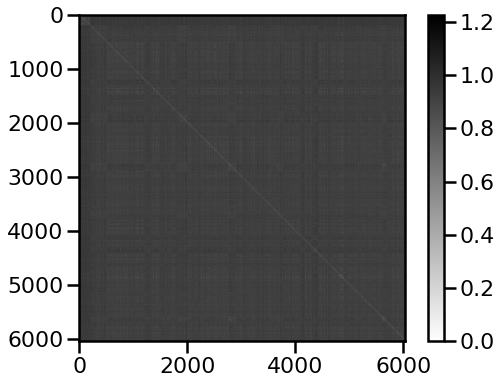

In [82]:
plt.imshow(distancias_w2v_dict,cmap='gray_r')
plt.colorbar()

Son muchos elementos, pero haciendo un zoom, se ven algunos conjuntos de nodos mas cercanos

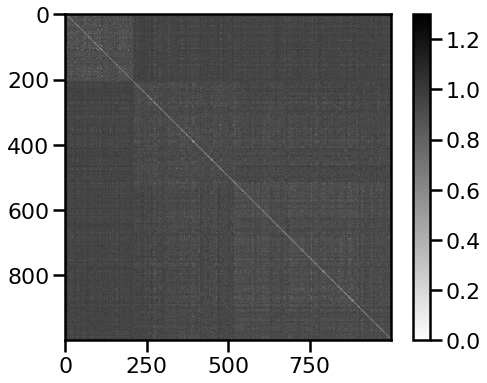

In [84]:
distancia_peque = distancias_w2v_dict[0:1000,0:1000]
plt.imshow(distancia_peque,cmap='gray_r',vmax=1.3,vmin=0)
plt.colorbar()

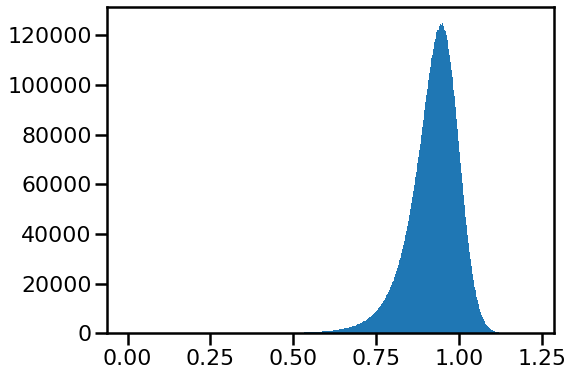

In [87]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')


El grafo:

In [88]:
G2 = nx.from_pandas_edgelist(df[['cue','R1','frec']],source='cue',target='R1',edge_attr=True)

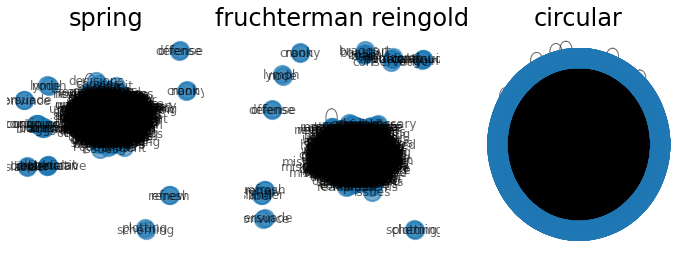

In [89]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G2, with_labels=True, alpha=0.6)
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G2)
nx.draw(G2,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G2)
nx.draw(G2,layout, with_labels=False,alpha=0.6)
plt.title('circular');

Aqui ya se ven comunidades

# Caracterizacion de los grafos

Red G_sww (G1)

In [90]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))

G1.number_of_nodes(), G1.number_of_edges()

Graph with 9906 nodes and 64051 edges
Is weigthed: False


(9906, 64051)

Red Gw2v

In [91]:
print(nx.info(G2))
print('Is weigthed:',nx.is_weighted(G2))

G2.number_of_nodes(), G2.number_of_edges()

Graph with 6039 nodes and 13337 edges
Is weigthed: False


(6039, 13337)

No se porque sale false en weighted, deberia ser true.

Grados por nodo

In [93]:
df_grados = pd.DataFrame(G2.degree,columns=['Node','Degree']).set_index('Node')
df_grados.sort_values('Degree',ascending=False).T

Node,money,water,food,car,music,green,love,animal,red,old,paper,happy,game,work,drink,dog,fruit,school,sad,cold,fire,sex,tree,time,small,house,country,up,good,bird,book,hot,man,death,hair,black,white,light,ball,child,...,resistance,resolution,tails,respect,responsible,restless,retired,cosmetics,revolver,antique,rifle,ripped,countries,rival,occur,covered,moo,anarchy,announce,wellness,piles,annoyance,reckless,herbs,helping,continuing,held,continuous,convince,refresh,renew,persuade,register,registered,rejected,irritating,heavenly,release,remain,Abel
Degree,111,99,88,72,66,61,52,50,48,47,44,44,43,42,41,41,40,40,40,40,38,38,37,37,36,36,35,35,35,34,34,34,34,34,33,32,32,32,31,31,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Viendolos en un histograma

<Figure size 720x288 with 0 Axes>

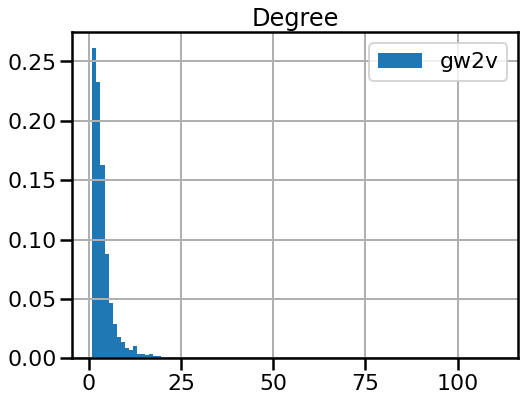

In [95]:
plt.figure(figsize=(10,4))
df_grados.hist(bins=100,density=True,label='gw2v');
plt.legend()


Grado de los nodos:

In [96]:
results = powerlaw.Fit(df_grados['Degree'])
results.power_law.alpha
results.power_law.sigma
results.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


(208.58987818562255, 4.009143803556933e-16)

Text(0.5, 0, 'grado')

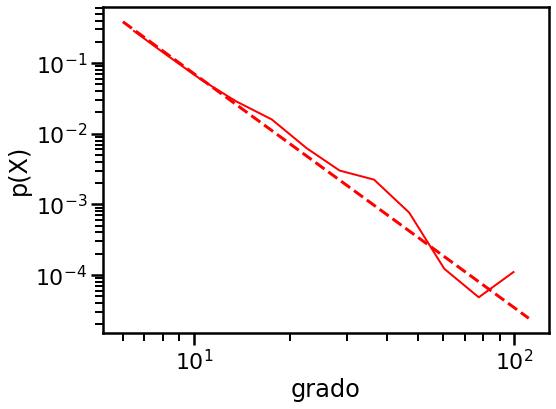

In [98]:
figPDF = results.plot_pdf(color='r', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"grado")